 # Training UNet Semantic Segmentation Model using Segmentation-Models Pytorch

 ### First, install and load required libraries

In [ ]:
!pip uninstall crcmod
!pip install --no-cache-dir -U crcmod
!pip install segmentation-models-pytorch
!pip install pytorch-lightning==1.9
!pip install albumentations
!pip install torch

In [ ]:
import os
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import albumentations as albu
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import PIL
import torch
import numpy as np
import segmentation_models_pytorch as smp
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Set random seed
pl.seed_everything(78, workers=True)

### Download training data

In [ ]:
# Load mean and std for scaling
!gsutil cp 'gs://res-id/cnn/training/example_prepped/mean_std_v1.npy' .
mean_std = np.load('./mean_std_v1.npy')

In [ ]:
# Download data for cloud storage
!gsutil cp gs://res-id/cnn/training/example_prepped/reservoirs_10band.zip .
!mkdir -p ./data
!unzip ./reservoirs_10band.zip -d ./data/

In [ ]:
DATA_DIR = './data/reservoirs_10band/'


x_train_dir = os.path.join(DATA_DIR, 'img_dir/train')
y_train_dir = os.path.join(DATA_DIR, 'ann_dir/train')

x_valid_dir = os.path.join(DATA_DIR, 'img_dir/val')
y_valid_dir = os.path.join(DATA_DIR, 'ann_dir/val')



### Set up Pytorch Dataset, including augmentation and preprocessing

In [ ]:
# Some helper functions

def get_training_augmentation():
    """Random combination of flipping, 90 deg rotation, and scaling in"""
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.RandomRotate90(p=1.0),
        albu.ShiftScaleRotate(scale_limit=(0, 0.25), rotate_limit=0, shift_limit=0.0, p=0.5, border_mode=0),
    ]
    return albu.Compose(train_transform, is_check_shapes=False)


def to_tensor(x, **kwargs):
    """Helper function to rearrange dimensions to match Torch Tensor expectations

    Before: xdim, ydim, bands
    After: bands, xdim, ydim
    """
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing():
    """Construct preprocessing transform

    In this case, all it does is rearrange dims (see to_tensor above)
    """

    _transform = [
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform, is_check_shapes=False)

def normalize_image(ar, mean_std):
    """Scale to mean == 0, std == 1"""
    return (ar - mean_std[0])/mean_std[1]


In [ ]:
class Dataset(BaseDataset):
    """Dataset Object Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """


    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
            mean_std = None
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id.replace('.tif', '.png')) for image_id in self.ids]

        # convert str names to class values on masks
        self.classes = classes
        self.class_values = [self.classes.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.mean_std = mean_std

    def __getitem__(self, i):

        # read data
        image = io.imread(self.images_fps[i])
        mask = io.imread(self.masks_fps[i])

        # extract certain classes from mask
        if len(self.classes) == 2:
          # Binary
          masks = [(mask == 1)]
        else:
          # Multi-class
          masks = [(mask == v) for v in self.class_values]

        mask = np.stack(masks, axis=-1).astype('float')

        if self.mean_std is not None:
            image = normalize_image(image, self.mean_std)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=(image.astype(np.float32)), mask=mask)
            image, mask = sample['image'], sample['mask']
            # if np.random.randint(0,1):
            gauss_scale = np.random.uniform(0, 0.1)
            image = image + np.random.normal(scale=gauss_scale, size=image.shape)


        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']


        #Convert to PIL
        return {'image':image, 'mask':mask}

    def __len__(self):
        return len(self.ids)

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    bands_to_view=[7, 9, 8]
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i ==0:
          plt.imshow(image[:,:, bands_to_view])
          print('Final mean', image.mean())
        else:
          plt.imshow(image)

    plt.show()

In [ ]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['background', 'reservoir'],
                  # augmentation=get_training_augmentation(),
                  mean_std=mean_std,
)

batch = dataset[5] # get some sample
visualize(
    image=batch['image'],
    reservoir_mask=batch['mask'].squeeze()
    )

### Define Unet Model

In [ ]:
class ResModel(pl.LightningModule):

    def __init__(self, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.Unet(encoder_name=encoder_name,
                               in_channels=in_channels,
                               classes=out_classes,
                               aux_params=dict(classes=out_classes)
        )

        # DiceLoss generally does a good job for image segmentation
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        # Input images are 640x640, masks are 500x500. So we apply a crop to only look at the middle
        self.crop_transform = torchvision.transforms.CenterCrop(500)

    def forward(self, image):
        # normalize image here
        mask = self.model(image)[0]
        return self.crop_transform(mask)

    def shared_step(self, batch, stage):

        ### Prep image ###
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0


        ### Prep mask ###
        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0


        ### Run forward prediction ###
        logits_mask = self.forward(image)


        ### Calculate loss and other metrics ###
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # Aggregate metrics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # Calculate IoU
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):

        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        # Learning rate, weight decay, and learning rate scheduler (decreasers by x0.9 per epoch)
        # These all may need to be tweaked in detail
        optim = torch.optim.Adam(self.parameters(), lr=0.0001, weight_decay=1e-5)
        return [optim], [torch.optim.lr_scheduler.ExponentialLR(optim, 0.9)]

In [ ]:
# Here we define the model. We use a resnet34 encoder "backbone", which is a pretty simple one that does a good job
model = ResModel(encoder_name="resnet34", in_channels=10, out_classes=1)

### Setup and run training

In [ ]:
# Stop training when validation IoU doesn't improve for 5 epochs
early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(monitor="valid_iou", mode='max', min_delta=0.00, patience=5)
# Save best validation dataset IoU model only
checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath="/content/", save_top_k=1, monitor="valid_iou", mode='max')
# Keep track of training and validation IoU while training
logger = pl.loggers.CSVLogger("/content/logs/", name="training_metrics")

In [ ]:
classes=['background', 'reservoir']

# Training dataset. Note that it gets augmentation
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    preprocessing=get_preprocessing(),
    augmentation=get_training_augmentation(),
    classes=classes,
    mean_std=mean_std,
)
# Validation dataset, no augmentation
valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    preprocessing=get_preprocessing(),
    classes=classes,
    mean_std=mean_std,
)

# DataLoaders that the trainer will use for loading datasets in batches
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=2)

In [ ]:
# Define trainer. In this case, we're using a GPU to accelerate training
# To attach a GPU in Colab, click: "Runtime -> Change runtime type -> T4 GPU -> Save"
trainer = pl.Trainer(
    gpus=1,
    max_epochs=50,
    callbacks=[early_stop_callback, checkpoint_callback],
    deterministic=True,
    logger=logger
)

# Fit
trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,
)

All done! After training, download the "ckpt" file corresponding to the best model

It should be appear in the sidebar:

Then you're done! Unless you want to try training again, you can delete the runtime by clicking "Runtime -> Disconnect and delete runtime"

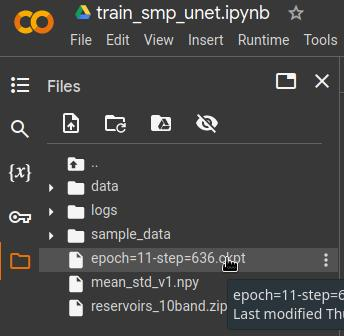